In [18]:
import pandas as pd
import numpy as np
import glob
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS 
from textblob import TextBlob
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from langdetect import detect_langs

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
Data = pd.read_csv('Reviews.csv')

In [3]:
Data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [4]:
# Add Helpfulness Column
Data['Helpfulness'] = Data['HelpfulnessNumerator']/Data['HelpfulnessDenominator']
Data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN


In [5]:
# Examine some text:
def show_some_sample_review(Score, Count_of_Records):
    sample_texts = Data[['Summary', 'Text']][Data['Score'] == Score][0:Count_of_Records].reset_index()
    for i in range(0, Count_of_Records):
        print('Summary: ' + sample_texts['Summary'][i] + ' --- Text: ' + sample_texts['Text'][i] + '\n')

In [6]:
show_some_sample_review(1, 10)

Summary: Not as Advertised --- Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Summary: My Cats Are Not Fans of the New Food --- Text: My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.

Summary: Nasty No flavor --- Text: The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again

Summary: Don't like it --- Text: This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.

Summary: stale product. --- Text: Arrived in 6 days and were so s

In [7]:
# Check distribution of Score: 
Distribution_Score = Data.groupby(['Score'])[['Text', 'Helpfulness']].count()
Distribution_Score['Percent_People_Indicate_Helpfulness'] = Distribution_Score['Helpfulness']/Distribution_Score['Text']
Distribution_Score

,Text,Helpfulness,Percent_People_Indicate_Helpfulness
Score,,,
1,52268,40002,0.765325
2,29769,19165,0.643791
3,42640,24217,0.567941
4,80655,38639,0.479065
5,363122,176379,0.485729


### Lower score have more users indicate helpfulness. 76% vs 47%

<AxesSubplot:xlabel='Helpfulness', ylabel='Count'>

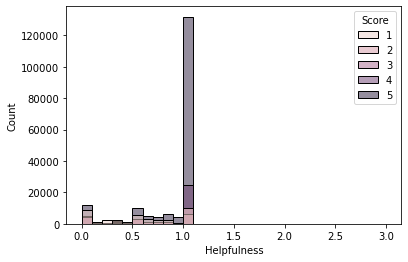

In [8]:
sns.histplot(data = Data, x = 'Helpfulness', hue = 'Score', binwidth = 0.1)

In [11]:
Data_Sample = Data[0:1000]
Data_Sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
995,996,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,1.0
996,997,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...",1.0
997,998,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...,1.0
998,999,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...,0.5


In [35]:
blob = TextBlob(Data_Sample.Text[0])
blob.sentiment

Sentiment(polarity=0.45, subjectivity=0.43333333333333335)

# Step 1: Feature creation

In [43]:
# Tokenize each item in the Text column
word_tokens = [word_tokenize(review) for review in Data_Sample.Text]
sent_tokens = [sent_tokenize(review) for review in Data_Sample.Text]
blob = [TextBlob(review) for review in Data_Sample.Text]

# Create an empty list to store the length of the Text
len_tokens = []
len_sent = []
polarity = []
subjectivity = []

# Iterate over the word_tokens list and determine the length of each item
for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))
    len_sent.append(len(sent_tokens[i]))
    polarity.append(blob[i].sentiment[0])
    subjectivity.append(blob[i].sentiment[1])

# Create a new feature for the lengh of each review
Data_Sample['n_words'] = len_tokens 
Data_Sample['n_sents'] = len_sent 
Data_Sample['polarity'] = polarity 
Data_Sample['len_sent'] = subjectivity 

<ipython-input-43-64cfbf64c180>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Sample['n_words'] = len_tokens
<ipython-input-43-64cfbf64c180>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Sample['n_sents'] = len_sent
<ipython-input-43-64cfbf64c180>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [44]:
Data_Sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,n_words,n_sents,polarity,len_sent
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,51,3,0.450000,0.433333
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN,37,2,-0.033333,0.762963
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,109,8,0.133571,0.448571
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,46,3,0.166667,0.533333
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,NaN,32,4,0.483333,0.637500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,1.0,112,7,0.229776,0.665897
996,997,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...",1.0,73,7,0.278125,0.646667
997,998,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...,1.0,57,3,0.341667,0.461667
998,999,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...,0.5,64,3,0.000000,0.593750


In [ ]:
# Step 2: Building a vectorizer

In [15]:
# Build the vectorizer
vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2), max_features=200, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(Data_Sample.Text)
# Create sparse matrix from the vectorizer
X = vect.transform(Data_Sample.Text)
# Create a DataFrame
reviews_transformed = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
print('Top 5 rows of the DataFrame: \n', reviews_transformed.head())

Top 5 rows of the DataFrame: 
    actually  add  amazon  amazon com   arrived  away  baby  bad  bag  bags   
0  0.000000  0.0     0.0         0.0  0.000000   0.0   0.0  0.0  0.0   0.0  \
1  0.405275  0.0     0.0         0.0  0.451466   0.0   0.0  0.0  0.0   0.0   
2  0.000000  0.0     0.0         0.0  0.000000   0.0   0.0  0.0  0.0   0.0   
3  0.000000  0.0     0.0         0.0  0.000000   0.0   0.0  0.0  0.0   0.0   
4  0.000000  0.0     0.0         0.0  0.000000   0.0   0.0  0.0  0.0   0.0   

   ...  vinegar  want  water  way  white  won  wonderful  work  year  years  
0  ...      0.0   0.0    0.0  0.0    0.0  0.0        0.0   0.0   0.0    0.0  
1  ...      0.0   0.0    0.0  0.0    0.0  0.0        0.0   0.0   0.0    0.0  
2  ...      0.0   0.0    0.0  0.0    0.0  0.0        0.0   0.0   0.0    0.0  
3  ...      0.0   0.0    0.0  0.0    0.0  0.0        0.0   0.0   0.0    0.0  
4  ...      0.0   0.0    0.0  0.0    0.0  0.0        0.0   0.0   0.0    0.0  

[5 rows x 200 columns]


In [ ]:
# Step 3: Building a classifier

In [17]:
# Define X and y
y = Data_Sample.Score
X = reviews_transformed
# Train/test split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=456)
# Train a logistic regression
log_reg = LogisticRegression().fit(X_train, y_train)
# Predict the labels
y_predicted = log_reg.predict(X_test)
# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on the test set:  0.63
[[0.    0.    0.    0.005 0.085]
 [0.    0.    0.    0.    0.05 ]
 [0.    0.    0.    0.    0.06 ]
 [0.    0.    0.    0.    0.16 ]
 [0.    0.    0.    0.01  0.63 ]]
